In [3]:
import tensorflow as tf
from tensorflow import keras

conv_base = keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False



model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [4]:
import os

base_dir = '/home/dhodun/ml-teaching-examples/cats_dogs'
data_dir = os.path.join(base_dir,'data')
model_dir = os.path.join(base_dir,'model')

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [5]:
model_dir

'/home/dhodun/ml-teaching-examples/cats_dogs/model'

In [6]:
estimator_model = keras.estimator.model_to_estimator(keras_model=model, model_dir=model_dir)

# input layer name
input_name = model.input_names[0]
input_name

INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2ca6548e90>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/home/dhodun/ml-teaching-examples/cats_dogs/model', '_save_summary_steps': 100}


'input_1'

In [7]:
def imgs_input_fn(filenames, labels=None, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [150, 150])
        image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        image.set_shape([150, 150, 3])
        image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    if labels is None:
        labels = [0]*len(filenames)
    labels=np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [8]:
import numpy as np

def unison_shuffled_copies(a, b):
    a = np.array(a)
    b = np.array(b)
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [9]:
CAT_LABEL = 0
DOG_LABEL = 1
train_cats = [os.path.join(train_cats_dir, file_name) for file_name in os.listdir(train_cats_dir)]
train_dogs = [os.path.join(train_dogs_dir, file_name) for file_name in os.listdir(train_dogs_dir)]
train_files = train_cats + train_dogs
train_labels = [CAT_LABEL]*len(train_cats)+[DOG_LABEL]*len(train_dogs)
train_files, train_labels = unison_shuffled_copies(train_files, train_labels)
test_cats = [os.path.join(test_cats_dir, file_name) for file_name in os.listdir(test_cats_dir)]
test_dogs = [os.path.join(test_dogs_dir, file_name) for file_name in os.listdir(test_dogs_dir)]
test_files = test_cats + test_dogs
test_labels = [CAT_LABEL]*len(test_cats)+[DOG_LABEL]*len(test_dogs)
test_files, test_labels = unison_shuffled_copies(test_files, test_labels)

In [10]:
print(train_files[:10])
print(train_labels[:10])

['/home/dhodun/ml-teaching-examples/cats_dogs/data/train/cats/cat.43.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.359.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.896.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.986.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.412.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.562.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.695.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/cats/cat.749.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/cats/cat.736.jpg'
 '/home/dhodun/ml-teaching-examples/cats_dogs/data/train/dogs/dog.713.jpg']
[0 1 1 1 1 1 1 0 0 1]


(20, 150, 150, 3)


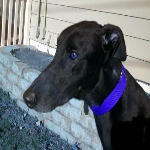

In [11]:
next_batch = imgs_input_fn(test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0][input_name]

print(x_d.shape)
img = keras.preprocessing.image.array_to_img(x_d[8])
img

In [12]:
next_batch = imgs_input_fn(test_files, labels=test_labels, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0][input_name]

print(x_d.shape)
img = keras.preprocessing.image.array_to_img(x_d[8])
img.show()

(20, 150, 150, 3)


In [13]:
estimator_model.train(input_fn=lambda: imgs_input_fn(test_files[:10], 
                                   labels=None, 
                                   perform_shuffle=False,
                                   batch_size=10))



INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/dhodun/ml-teaching-examples/cats_dogs/model/


NotFoundError: Key block2_conv1/bias not found in checkpoint
	 [[Node: save/RestoreV2_8 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_8/tensor_names, save/RestoreV2_8/shape_and_slices)]]
	 [[Node: save/RestoreV2_57/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_134_save/RestoreV2_57", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'save/RestoreV2_8', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dhodun/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/dhodun/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dhodun/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dhodun/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dhodun/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dhodun/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dhodun/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-2bf60ff9affc>", line 1, in <module>
    estimator_model.train(input_fn=lambda: imgs_input_fn(test_files[:10],
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/estimator/estimator.py", line 302, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/estimator/estimator.py", line 780, in _train_model
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 368, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 673, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 493, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 851, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 856, in _create_session
    return self._sess_creator.create_session()
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 554, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 419, in create_session
    self._scaffold.finalize()
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/monitored_session.py", line 212, in finalize
    self._saver.build()
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 745, in _build_internal
    restore_sequentially, reshape)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 470, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/dhodun/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key block2_conv1/bias not found in checkpoint
	 [[Node: save/RestoreV2_8 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_8/tensor_names, save/RestoreV2_8/shape_and_slices)]]
	 [[Node: save/RestoreV2_57/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_134_save/RestoreV2_57", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
tf.read_file('/home/dhodun/ml-teaching-examples/cats_dogs/data/test/cats/cat.1999.jpg')

In [ ]:
# Import TensorFlow.
import tensorflow as tf

# Import TensorFlow eager execution support (subject to future changes).
import tensorflow.contrib.eager as tfe

# Enable eager execution
tfe.enable_eager_execution()